## Distribution of Individual per Game Stats
#### Looking at how the individual stats are distributed, as that will inform the scale we use to assign ratings

In [3]:
import numpy as np
from numpy import meshgrid
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

Importing csv files

In [4]:
all_games_df = pd.DataFrame(data = pd.read_csv('all_games_data.csv', index_col=0))
field_pos_df = pd.DataFrame(data = pd.read_csv('all_games_field_pos_data.csv', index_col=0))
recruit_df = pd.DataFrame(data = pd.read_csv('all_teams_recruit_data.csv', index_col=0))

Cleaning the time-based columns into a math usable format

In [5]:
all_games_df['away_possessionTime'] = all_games_df['away_possessionTime'].astype(str)
all_games_df['home_possessionTime'] = all_games_df['home_possessionTime'].astype(str)

all_games_df[['away_possession_minutes', 'away_possession_seconds']] = all_games_df['away_possessionTime'].str.split(':', expand=True)
all_games_df[['home_possession_minutes', 'home_possession_seconds']] = all_games_df['home_possessionTime'].str.split(':', expand=True)


all_games_df['away_possession_minutes'] = all_games_df['away_possession_minutes'].astype(float)
all_games_df['away_possession_seconds'] = all_games_df['away_possession_seconds'].astype(float)
all_games_df['home_possession_minutes'] = all_games_df['home_possession_minutes'].astype(float)
all_games_df['home_possession_seconds'] = all_games_df['home_possession_seconds'].astype(float)

all_games_df['away_poss_total_sec'] = (all_games_df['away_possession_seconds'] + (all_games_df['away_possession_minutes'] * 60.0))
all_games_df['home_poss_total_sec'] = (all_games_df['home_possession_seconds'] + (all_games_df['home_possession_minutes'] * 60.0))

Creating a dataframe that reshapes into 1 row per team per game. Allows for slightly easier grouping later on down the road

In [6]:
home_cols = [col for col in all_games_df.columns if 'home_' in col]
#still want game ID, year, and week. Seems useful.
home_cols.extend(['id', 'year', 'week'])

away_cols = [col for col in all_games_df.columns if 'away_' in col]
away_cols.extend(['id', 'year', 'week'])

home_df = all_games_df.loc[:, home_cols]
away_df = all_games_df.loc[:, away_cols]

away_df.columns = away_df.columns.str.removeprefix('away_')
home_df.columns = home_df.columns.str.removeprefix('home_')

#final_df is 1 row per team per game (2 rows per game)
frames = [away_df, home_df]
final_df = pd.concat(frames)

Creating a list of the top 133 teams, as these might be more of a realistic population to base ratings off of
(they have the most complete data and also play the most competitive games)

In [7]:
#limiting df results to top 133 ranked schools this year according to cbs sports
import requests
response = requests.get(url="https://www.cbssports.com/college-football/rankings/cbs-sports-rankings/")
response.status_code

import bs4
from bs4 import BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')
table_body = soup.find('table').tbody

#Don't really care about the order, they just need to be in here
top_teams = [span.text for span in table_body.find_all('span',{'class': 'TeamName'})]

Re-typing the object classes in final_df and creating better math-able columns for distributions

In [8]:
# need to adjust some columns and data types so that we can get a mean, since they're objects

final_df['thirdDownEff'] = final_df['thirdDownEff'].astype(str)
final_df['fourthDownEff'] = final_df['fourthDownEff'].astype(str)
final_df['completionAttempts'] = final_df['completionAttempts'].astype(str)
# final_df['totalPenaltiesYards'] = final_df['totalPenaltiesYards'].astype(str)


final_df[['thirdDownConverts','thirdDownAttempts']]= final_df['thirdDownEff'].str.split('-', expand=True)
final_df[['fourthDownConverts', 'fourthDownAttempts']] = final_df['fourthDownEff'].str.split('-', expand=True)
final_df[['completions','passAttempts']] = final_df['completionAttempts'].str.split('-', expand=True)
# final_df[['totalPenalties','penaltyYards']] = final_df['totalPenaltiesYards'].str.split('-', expand=True)


final_df['thirdDownConverts'] = final_df['thirdDownConverts'].astype(float)
final_df['thirdDownAttempts'] = final_df['thirdDownAttempts'].astype(float)
final_df['fourthDownConverts'] = final_df['fourthDownConverts'].astype(float)
final_df['fourthDownAttempts'] = final_df['fourthDownAttempts'].astype(float)
final_df['completions'] = final_df['completions'].astype(float)
final_df['passAttempts'] = final_df['passAttempts'].astype(float)
# final_df['totalPenalties'] = final_df['totalPenalties'].astype(float)
# final_df['penaltyYards'] = final_df['penaltyYards'].astype(float)

final_df['completions'] = np.nan_to_num(final_df['completions'])
final_df['thirdDownConverts'] = np.nan_to_num(final_df['completions'])
final_df['fourthDownConverts'] = np.nan_to_num(final_df['completions'])


# # Do I care about getting an average? Idk
final_df['thirdDownEff'] = ((final_df['thirdDownConverts']) / (final_df['thirdDownAttempts']))
final_df['passCompletionPercentage'] = ((final_df['completions']) / (final_df['passAttempts']))
final_df['fourthDownEff'] = ((final_df['fourthDownConverts']) / (final_df['fourthDownAttempts']))


final_df['thirdDownEff'] = final_df['thirdDownEff'].astype(float)
final_df['fourthDownEff'] = final_df['fourthDownEff'].astype(float)

Merging field position info 

In [9]:
final_df = pd.merge(final_df, field_pos_df,  how='left', left_on= ['id','school'], right_on = ['game_id','team'])
final_df = final_df.drop(columns=['game_id','team'])
# Final iteration of final_df
final_df

,school,school_id,points,fumblesRecovered,rushingTDs,passingTDs,kickReturnYards,kickReturnTDs,kickReturns,kickingPoints,...,year,week,thirdDownConverts,thirdDownAttempts,fourthDownConverts,fourthDownAttempts,completions,passAttempts,passCompletionPercentage,avg_field_position
0,Navy,2426,17,0.0,2.0,0.0,64.0,0.0,4.0,5.0,...,2014,1,2.0,12.0,2.0,1.0,2.0,4.0,0.500000,78.6
1,UAB,5,48,1.0,4.0,2.0,64.0,0.0,2.0,12.0,...,2014,1,13.0,14.0,13.0,0.0,13.0,20.0,0.650000,65.4
2,UMass,113,7,0.0,0.0,1.0,95.0,0.0,4.0,1.0,...,2014,1,9.0,11.0,9.0,1.0,9.0,22.0,0.409091,69.7
3,UCF,2116,24,1.0,2.0,1.0,142.0,0.0,5.0,6.0,...,2014,1,12.0,13.0,12.0,2.0,12.0,22.0,0.545455,63.3
4,Houston,248,7,1.0,1.0,0.0,89.0,0.0,6.0,1.0,...,2014,1,25.0,16.0,25.0,4.0,25.0,50.0,0.500000,56.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,SMU,2567,26,0.0,1.0,1.0,41.0,0.0,2.0,14.0,...,2023,14,19.0,16.0,19.0,1.0,19.0,33.0,0.575758,NaN
16212,Oregon,2483,31,0.0,1.0,3.0,NaN,NaN,NaN,7.0,...,2023,14,21.0,10.0,21.0,2.0,21.0,34.0,0.617647,NaN
16213,Appalachian State,2026,23,1.0,3.0,0.0,37.0,0.0,2.0,5.0,...,2023,14,28.0,16.0,28.0,3.0,28.0,39.0,0.717949,NaN
16214,New Mexico State,166,35,0.0,1.0,4.0,44.0,0.0,3.0,5.0,...,2023,14,21.0,11.0,21.0,2.0,21.0,35.0,0.600000,NaN


### Distribution of Stats

In [10]:
final_df.columns

Index(['school', 'school_id', 'points', 'fumblesRecovered', 'rushingTDs',
       'passingTDs', 'kickReturnYards', 'kickReturnTDs', 'kickReturns',
       'kickingPoints', 'interceptionYards', 'interceptionTDs',
       'passesIntercepted', 'firstDowns', 'thirdDownEff', 'fourthDownEff',
       'totalYards', 'netPassingYards', 'completionAttempts', 'yardsPerPass',
       'rushingYards', 'rushingAttempts', 'yardsPerRushAttempt',
       'totalPenaltiesYards', 'turnovers', 'fumblesLost', 'interceptions',
       'possessionTime', 'puntReturnYards', 'puntReturnTDs', 'puntReturns',
       'totalFumbles', 'tacklesForLoss', 'defensiveTDs', 'tackles', 'sacks',
       'qbHurries', 'passesDeflected', 'possession_minutes',
       'possession_seconds', 'poss_total_sec', 'id', 'year', 'week',
       'thirdDownConverts', 'thirdDownAttempts', 'fourthDownConverts',
       'fourthDownAttempts', 'completions', 'passAttempts',
       'passCompletionPercentage', 'avg_field_position'],
      dtype='object')

In [11]:
pd.cut(final_df.netPassingYards,25).value_counts()

(176.16, 205.52]    1892
(205.52, 234.88]    1864
(234.88, 264.24]    1817
(146.8, 176.16]     1683
(264.24, 293.6]     1550
(117.44, 146.8]     1345
(293.6, 322.96]     1288
(322.96, 352.32]     956
(88.08, 117.44]      949
(58.72, 88.08]       646
(352.32, 381.68]     635
(381.68, 411.04]     455
(29.36, 58.72]       330
(411.04, 440.4]      260
(440.4, 469.76]      164
(-0.734, 29.36]      157
(469.76, 499.12]     112
(499.12, 528.48]      60
(528.48, 557.84]      24
(557.84, 587.2]       11
(587.2, 616.56]       10
(616.56, 645.92]       4
(704.64, 734.0]        2
(645.92, 675.28]       0
(675.28, 704.64]       0
Name: netPassingYards, dtype: int64

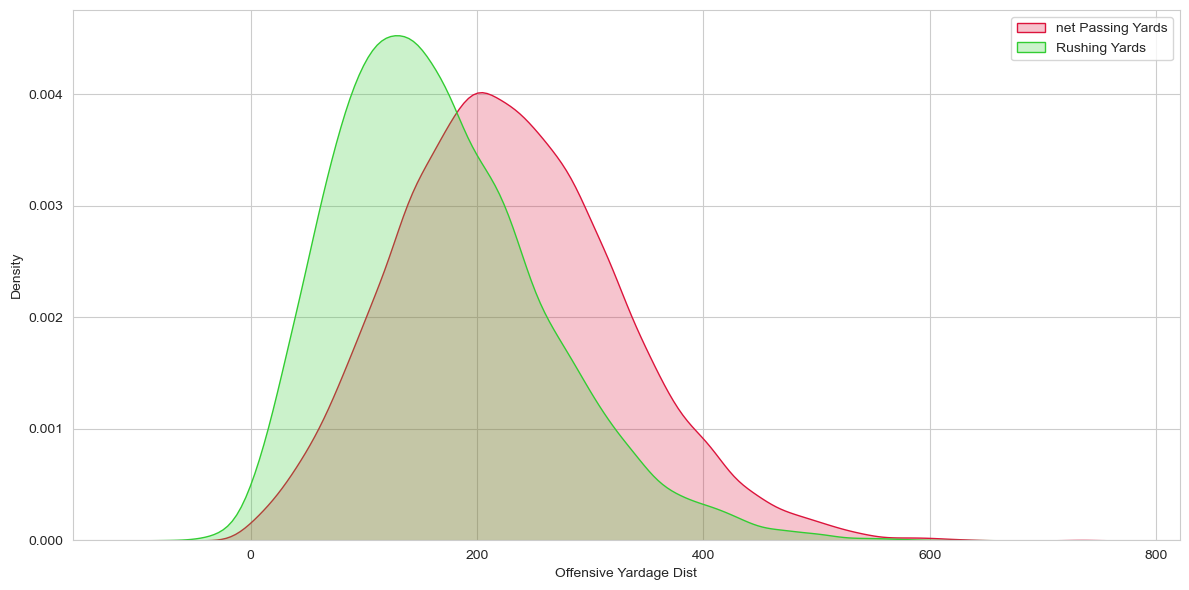

In [31]:
# plt.figure(figsize=(10,8))

# pd.cut(final_df.netPassingYards,25).value_counts().plot(kind = 'bar')



# print(final_df.netPassingYards.describe())
# print(final_df.netPassingYards.median())


fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=final_df.netPassingYards,
            color='crimson', label='net Passing Yards', fill=True, ax=ax)
sns.kdeplot(data=final_df.rushingYards,
            color='limegreen', label='Rushing Yards', fill=True, ax=ax)
ax.legend()

plt.xlabel('Offensive Yardage Dist')
plt.tight_layout()
plt.show()

# plt.plot(pd.cut(final_df.netPassingYards,25),pd.cut(final_df.netPassingYards,25).value_counts())
# plt.ylim(bottom = 0, top = 1)

# plt.ylabel('')
# plt.xlabel('win rate')
# plt.show()

In [37]:
pd.set_option('display.max_columns', 500)
final_df.describe()

,school_id,points,fumblesRecovered,rushingTDs,passingTDs,kickReturnYards,kickReturnTDs,kickReturns,kickingPoints,interceptionYards,interceptionTDs,passesIntercepted,firstDowns,thirdDownEff,fourthDownEff,totalYards,netPassingYards,yardsPerPass,rushingYards,rushingAttempts,yardsPerRushAttempt,turnovers,fumblesLost,interceptions,puntReturnYards,puntReturnTDs,puntReturns,totalFumbles,tacklesForLoss,defensiveTDs,tackles,sacks,qbHurries,passesDeflected,possession_minutes,possession_seconds,poss_total_sec,id,year,week,thirdDownConverts,thirdDownAttempts,fourthDownConverts,fourthDownAttempts,completions,passAttempts,passCompletionPercentage,avg_field_position
count,16216.000000,16216.000000,16214.00000,16213.000000,16211.000000,14151.000000,14151.000000,14151.000000,15944.000000,9041.000000,9041.000000,9041.000000,16214.000000,1.621300e+04,16210.0,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,11487.000000,11487.000000,11487.000000,9317.000000,12812.000000,12812.000000,12812.000000,12812.000000,12812.000000,12812.000000,16199.000000,16199.000000,16199.000000,1.621600e+04,16216.000000,16216.000000,16216.000000,16214.000000,16216.000000,16214.000000,16216.000000,16214.000000,16211.000000,122.000000
mean,932.501603,28.106315,0.72092,1.705545,1.632657,60.898735,0.033072,3.006572,6.717825,19.033846,0.156177,1.515319,20.533736,inf,inf,395.535278,228.451523,7.430356,167.086345,38.144135,4.211940,1.490502,0.646232,0.844270,16.981283,0.052668,2.030730,1.685199,6.086559,0.168826,40.440368,2.204184,2.294177,3.455198,29.520588,29.524909,1800.760170,4.010681e+08,2018.481746,7.050074,18.742723,14.222277,18.742723,1.702356,18.742723,31.315653,0.593912,68.714754
std,1069.437134,14.947066,0.99478,1.511619,1.369570,42.783673,0.185046,1.810968,3.558558,25.355271,0.386366,0.777599,6.071832,NaN,NaN,123.764649,98.452149,2.814547,92.041672,10.010967,1.802629,1.269565,0.820194,0.948751,23.248764,0.234039,1.238991,1.416932,3.193115,0.436761,13.231507,1.914532,2.549613,2.472064,4.774744,17.286578,285.784349,2.945107e+05,2.915488,4.105450,7.384872,3.016361,7.384872,1.406112,7.384872,10.471251,0.120607,8.315679
min,2.000000,0.000000,0.00000,0.000000,0.000000,-42.000000,0.000000,1.000000,0.000000,-97.000000,0.000000,1.000000,0.000000,0.000000e+00,0.0,-33.000000,0.000000,0.000000,-73.000000,0.000000,-3.100000,0.000000,0.000000,0.000000,-27.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,730.000000,4.005476e+08,2014.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.100000
25%,127.000000,17.000000,0.00000,1.000000,1.000000,28.000000,0.000000,2.000000,4.000000,0.000000,0.000000,1.000000,16.000000,1.000000e+00,7.0,308.000000,159.000000,5.600000,100.000000,31.000000,3.000000,1.000000,0.000000,0.000000,2.000000,0.000000,1.000000,1.000000,4.000000,0.000000,32.000000,1.000000,0.000000,2.000000,26.000000,15.000000,1607.000000,4.008693e+08,2016.000000,3.000000,14.000000,12.000000,14.000000,1.000000,14.000000,24.000000,0.520000,63.350000
50%,251.000000,27.000000,0.00000,1.000000,1.000000,51.000000,0.000000,3.000000,7.000000,9.000000,0.000000,1.000000,21.000000,1.294118e+00,12.0,394.000000,223.000000,7.100000,155.000000,37.000000,4.100000,1.000000,0.000000,1.000000,10.000000,0.000000,2.000000,1.000000,6.000000,0.000000,39.000000,2.000000,2.000000,3.000000,30.000000,30.000000,1800.000000,4.010217e+08,2018.000000,7.000000,18.000000,14.000000,18.000000,1.000000,18.000000,31.000000,0.600000,70.800000
75%,2229.000000,38.000000,1.00000,3.000000,2.000000,84.500000,0.000000,4.000000,9.000000,30.000000,0.000000,2.000000,25.000000,1.666667e+00,26.0,479.000000,292.000000,8.900000,222.000000,44.000000,5.300000,2.000000,1.000000,1.000000,23.000000,0.000000,3.000000,2.000000,8.000000,0.000000,46.000000,3.000000,3.000000,5.000000,33.000000,44.000000,1993.000000,4.013010e+08,2021.000000,11.000000,23.000000,16.000000,23.000000,2.00000

#### Jotting down some of the stats that looked a bit non-normal with their distributions:
- fumbles recovered
- interception yards (had some negative values?)
- avg_field_position - looked exponential then severe drop off
    - increased smoothing reduced this effect, but you can see it a little bit
- qb hurries - exponential decreasing
- sacks - exponential decreasing
- defensive TDs - you either get them or you don't. And you basically only ever get 1 
- punt return yards - semi normal but maybe exponential? overall it's usually 0, but that might be bad data

<AxesSubplot:xlabel='avg_field_position', ylabel='Density'>

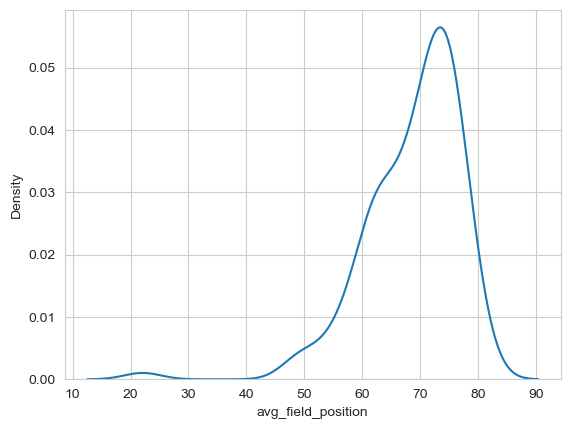

In [64]:
sns.kdeplot(data = final_df, x = 'avg_field_position', bw_adjust=1)